# 3W Real Dataset 

# Improts & Configuration

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import os

from pyspark.sql import SparkSession, Window
from pyspark.sql import functions as F
from pyspark.sql.functions import col, when, count, mean, isnan, expr, lit, countDistinct, round
from pyspark.sql.types import IntegerType, StringType, StructType, StructField
from functools import reduce


In [2]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("3W Real Dataset") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/13 00:28:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Loading the Datasets

In [3]:
# Load the dataset with Spark
data_path = "/Users/ghazijalal/Documents/IE University/Term 3/CAPSTONE PROJECT/Git/CapStone/Data/real_instances.parquet"
spark_df_real = spark.read.parquet(data_path)

In [4]:
# Quick view of data schema
spark_df_real.printSchema()

root
 |-- timestamp: string (nullable = true)
 |-- label: long (nullable = true)
 |-- well: string (nullable = true)
 |-- id: long (nullable = true)
 |-- ABER-CKGL: double (nullable = true)
 |-- ABER-CKP: double (nullable = true)
 |-- ESTADO-DHSV: double (nullable = true)
 |-- ESTADO-M1: double (nullable = true)
 |-- ESTADO-M2: double (nullable = true)
 |-- ESTADO-PXO: double (nullable = true)
 |-- ESTADO-SDV-GL: double (nullable = true)
 |-- ESTADO-SDV-P: double (nullable = true)
 |-- ESTADO-W1: double (nullable = true)
 |-- ESTADO-W2: double (nullable = true)
 |-- ESTADO-XO: double (nullable = true)
 |-- P-ANULAR: double (nullable = true)
 |-- P-JUS-BS: double (nullable = true)
 |-- P-JUS-CKGL: double (nullable = true)
 |-- P-JUS-CKP: double (nullable = true)
 |-- P-MON-CKGL: double (nullable = true)
 |-- P-MON-CKP: double (nullable = true)
 |-- P-MON-SDV-P: double (nullable = true)
 |-- P-PDG: double (nullable = true)
 |-- PT-P: double (nullable = true)
 |-- P-TPT: double (nullable 

In [5]:
# Basic Data Exploration with Spark SQL
record_count = spark_df_real.count()
print(f"Total records: {record_count}")

Total records: 32872250


# Dataset References

### Event Reference Table

In [6]:
# Define label_descriptions dictionary and convert it to Spark DataFrame
label_descriptions = {
    0: 'NORMAL',
    1: 'ABRUPT INCREASE OF BSW',
    2: 'SPURIOUS CLOSURE OF DHSV',
    3: 'SEVERE SLUGGING',
    4: 'FLOW INSTABILITY',
    5: 'RAPID PRODUCTIVITY LOSS',
    6: 'QUICK RESTRICTION IN PCK',
    7: 'SCALING IN PCK',
    8: 'HYDRATE IN PRODUCTION LINE',
    9: 'HYDRATE IN SERVICE LINE'
}

label_schema = StructType([
    StructField("label", IntegerType(), True),
    StructField("Description", StringType(), True)
])

label_descriptions_df = spark.createDataFrame(
    [(k, v) for k, v in label_descriptions.items()], schema=label_schema
)

# Display label descriptions
label_descriptions_df.show(truncate=False)

+-----+--------------------------+
|label|Description               |
+-----+--------------------------+
|0    |NORMAL                    |
|1    |ABRUPT INCREASE OF BSW    |
|2    |SPURIOUS CLOSURE OF DHSV  |
|3    |SEVERE SLUGGING           |
|4    |FLOW INSTABILITY          |
|5    |RAPID PRODUCTIVITY LOSS   |
|6    |QUICK RESTRICTION IN PCK  |
|7    |SCALING IN PCK            |
|8    |HYDRATE IN PRODUCTION LINE|
|9    |HYDRATE IN SERVICE LINE   |
+-----+--------------------------+



### Feature Reference Table

In [7]:
# Define tags and human-readable names for the reference table
tags = {
    'ABER-CKGL': '%',
    'ABER-CKP': '%',
    'ESTADO-DHSV': '[0, 0.5, 1]',
    'ESTADO-M1': '[0, 0.5, 1]',
    'ESTADO-M2': '[0, 0.5, 1]',
    'ESTADO-PXO': '[0, 0.5, 1]',
    'ESTADO-SDV-GL': '[0, 0.5, 1]',
    'ESTADO-SDV-P': '[0, 0.5, 1]',
    'ESTADO-W1': '[0, 0.5, 1]',
    'ESTADO-W2': '[0, 0.5, 1]',
    'ESTADO-XO': '[0, 0.5, 1]',
    'P-ANULAR': 'Pa',
    'P-JUS-BS': 'Pa',
    'P-JUS-CKGL': 'Pa',
    'P-JUS-CKP': 'Pa',
    'P-MON-CKGL': 'Pa',
    'P-MON-CKP': 'Pa',
    'P-MON-SDV-P': 'Pa',
    'P-PDG': 'Pa',
    'PT-P': 'Pa',
    'P-TPT': 'Pa',
    'QBS': 'm3/s',
    'QGL': 'm3/s',
    'T-JUS-CKP': '°C',
    'T-MON-CKP': '°C',
    'T-PDG': '°C',
    'T-TPT': '°C',
    'class': 'Label',
    'state': 'Operational Status',
    'label': 'Instance Label',
    'well': 'Well Name',
    'id': 'Instance ID',
    'Instance': 'Instance ID (Manual)',
    'DataType': 'Dataset Type',
    'timestamp': 'Timestamp'
}

names = [
    'Opening of the GLCK (gas lift choke)',
    'Opening of the PCK (production choke)',
    'State of the DHSV (downhole safety valve)',
    'State of the PMV (production master valve)',
    'State of the AMV (annulus master valve)',
    'State of the PXO (pig-crossover) valve',
    'State of the gas lift SDV (shutdown valve)',
    'State of the production SDV (shutdown valve)',
    'State of the PWV (production wing valve)',
    'State of the AWV (annulus wing valve)',
    'State of the XO (crossover) valve',
    'Pressure in the well annulus',
    'Downstream pressure of the SP (service pump)',
    'Downstream pressure of the GLCK (gas lift choke)',
    'Downstream pressure of the PCK (production choke)',
    'Upstream pressure of the GLCK (gas lift choke)',
    'Upstream pressure of the PCK (production choke)',
    'Upstream pressure of the production SDV (shutdown valve)',
    'Pressure at the PDG (permanent downhole gauge)',
    'Downstream pressure of the PWV in the production tube',
    'Pressure at the TPT (temperature and pressure transducer)',
    'Flow rate at the SP (service pump)',
    'Gas lift flow rate',
    'Downstream temperature of the PCK (production choke)',
    'Upstream temperature of the PCK (production choke)',
    'Temperature at the PDG (permanent downhole gauge)',
    'Temperature at the TPT (temperature and pressure transducer)',
    'Label of the observation',
    'Well operational status',
    'Instance label (event type)',
    'Well name',
    'Instance identifier',
    'Instance count based on manual labeling',
    'Real , simulated or hand-drawn',
    'Timestamp'
]

# Convert reference table to a Spark DataFrame
reference_schema = StructType([
    StructField("Tag", StringType(), True),
    StructField("Name", StringType(), True),
    StructField("Unit", StringType(), True)
])

reference_table = spark.createDataFrame(
    [(tag, name, unit) for tag, name, unit in zip(tags.keys(), names, tags.values())],
    schema=reference_schema
)

# Display reference table. Do not truncate the columns. Show all rows.
reference_table.show(truncate=False, n=999)

+-------------+------------------------------------------------------------+--------------------+
|Tag          |Name                                                        |Unit                |
+-------------+------------------------------------------------------------+--------------------+
|ABER-CKGL    |Opening of the GLCK (gas lift choke)                        |%                   |
|ABER-CKP     |Opening of the PCK (production choke)                       |%                   |
|ESTADO-DHSV  |State of the DHSV (downhole safety valve)                   |[0, 0.5, 1]         |
|ESTADO-M1    |State of the PMV (production master valve)                  |[0, 0.5, 1]         |
|ESTADO-M2    |State of the AMV (annulus master valve)                     |[0, 0.5, 1]         |
|ESTADO-PXO   |State of the PXO (pig-crossover) valve                      |[0, 0.5, 1]         |
|ESTADO-SDV-GL|State of the gas lift SDV (shutdown valve)                  |[0, 0.5, 1]         |
|ESTADO-SDV-P |State

# Unique Values

In [8]:
# Unique Values Function without stack
def generate_unique_values_table(reference_table, spark_df, column_name):
    # Step 1: Generate unique value counts for each column in the dataset
    unique_counts = [(c, spark_df.select(countDistinct(col(c)).alias("unique_count")).first()["unique_count"])
                     for c in spark_df.columns]
    
    # Step 2: Convert list of tuples to Spark DataFrame
    unique_counts_df = spark.createDataFrame(unique_counts, ["Tag", column_name])
    
    # Step 3: Join with reference table to align unique counts with tags
    unique_values_df = reference_table.join(unique_counts_df, on="Tag", how="left")
    
    return unique_values_df


In [9]:
# Generate Unique Values Table
unique_values_table = generate_unique_values_table(reference_table, spark_df_real, 'Unique Values (Real)')
unique_values_table.show(truncate=False, n=999)

24/11/13 00:29:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/13 00:29:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/13 00:29:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/13 00:29:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/13 00:29:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/13 00:29:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/13 00:29:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/13 00:29:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/13 00:29:09 WARN RowBasedKeyValueBatch: Calling spill() on

+-------------+------------------------------------------------------------+--------------------+--------------------+
|Tag          |Name                                                        |Unit                |Unique Values (Real)|
+-------------+------------------------------------------------------------+--------------------+--------------------+
|ABER-CKGL    |Opening of the GLCK (gas lift choke)                        |%                   |300484              |
|ABER-CKP     |Opening of the PCK (production choke)                       |%                   |850210              |
|ESTADO-DHSV  |State of the DHSV (downhole safety valve)                   |[0, 0.5, 1]         |2                   |
|ESTADO-M1    |State of the PMV (production master valve)                  |[0, 0.5, 1]         |2                   |
|ESTADO-PXO   |State of the PXO (pig-crossover) valve                      |[0, 0.5, 1]         |2                   |
|ESTADO-M2    |State of the AMV (annulus master 

In [10]:
def add_value_type_column(unique_values_table):
    # Step 1: Define conditions for the 'Value Type' column based on 'Unique Values (Real)'
    unique_values_table = unique_values_table.withColumn(
        "Value Type",
        when(col("Unique Values (Real)") == 0, "Empty")
        .when(col("Unique Values (Real)") <= 3, "Categorical")
        .when(col("Tag").isin("label", "class", "state"), "Classifier")
        .when(col("Tag").isin("well", "id", "Instance"), "Identifier")
        .when(col("Tag") == "DataType", "Dataset")
        .when(col("Tag") == "timestamp", "Timestamp")
        .otherwise("Continuous")
    )
    
    # Step 2: Reorder columns: place 'Value Type' after 'Unit'
    column_order = [
        'Tag', 'Name', 'Unit', 'Value Type', 'Unique Values (Real)'
    ]
    
    # Select and reorder columns as specified
    unique_values_table = unique_values_table.select(*column_order)
    
    return unique_values_table

In [11]:
unique_values_table = add_value_type_column(unique_values_table)
unique_values_table.show(truncate=False, n=999)

+-------------+------------------------------------------------------------+--------------------+-----------+--------------------+
|Tag          |Name                                                        |Unit                |Value Type |Unique Values (Real)|
+-------------+------------------------------------------------------------+--------------------+-----------+--------------------+
|ABER-CKGL    |Opening of the GLCK (gas lift choke)                        |%                   |Continuous |300484              |
|ABER-CKP     |Opening of the PCK (production choke)                       |%                   |Continuous |850210              |
|ESTADO-DHSV  |State of the DHSV (downhole safety valve)                   |[0, 0.5, 1]         |Categorical|2                   |
|ESTADO-M1    |State of the PMV (production master valve)                  |[0, 0.5, 1]         |Categorical|2                   |
|ESTADO-PXO   |State of the PXO (pig-crossover) valve                      |[0, 0.5

# Missing Values

In [12]:
def generate_missing_values_table(reference_table, spark_df, column_name):
    record_count = spark_df.count()
    
    # Step 1: Calculate the percentage of missing values for each column
    missing_counts = []
    for c in spark_df.columns:
        # Calculate the percentage of rows where the value is either NaN or Null
        missing_percentage = (spark_df.filter((col(c).isNull()) | (isnan(col(c)))).count() / record_count) * 100
        missing_counts.append((c, missing_percentage))
    
    # Step 2: Convert the list of tuples to a Spark DataFrame
    missing_counts_df = spark.createDataFrame(missing_counts, ["Tag", column_name])
    
    # Step 3: Round the missing values percentage to the nearest decimal
    missing_counts_df = missing_counts_df.withColumn(column_name, round(col(column_name), 1))
    
    # Step 4: Join with the reference table to align missing values with tags
    missing_values_df = reference_table.join(missing_counts_df, on="Tag", how="left")
    
    return missing_values_df

In [13]:
# Generate Missing Values Table
unique_values_table_with_missing = generate_missing_values_table(unique_values_table, spark_df_real, 'Missing Values (%) (Real)')
unique_values_table_with_missing.show(truncate=False, n=999)

+-------------+------------------------------------------------------------+--------------------+-----------+--------------------+-------------------------+
|Tag          |Name                                                        |Unit                |Value Type |Unique Values (Real)|Missing Values (%) (Real)|
+-------------+------------------------------------------------------------+--------------------+-----------+--------------------+-------------------------+
|ABER-CKGL    |Opening of the GLCK (gas lift choke)                        |%                   |Continuous |300484              |74.2                     |
|ABER-CKP     |Opening of the PCK (production choke)                       |%                   |Continuous |850210              |62.5                     |
|ESTADO-DHSV  |State of the DHSV (downhole safety valve)                   |[0, 0.5, 1]         |Categorical|2                   |57.8                     |
|ESTADO-M1    |State of the PMV (production master valve) 

In [14]:
def plot_histogram_single_dataset(spark_df, label_column, count_basis, df_name='Dataset'):
    # Count unique values based on the count_basis column
    label_counts = spark_df.groupBy(label_column).agg(countDistinct(count_basis).alias("count"))
    label_counts_df = label_counts.toPandas()  # Convert to Pandas DataFrame for plotting

    # Sort the DataFrame by the label_column
    label_counts_df = label_counts_df.sort_values(by=label_column).reset_index(drop=True)

    # Plot the histogram
    label_counts_df.plot(kind='bar', x=label_column, y="count", figsize=(10, 6))
    plt.title(f'Unique {count_basis} Counts by {label_column}')
    plt.xlabel(label_column)
    plt.ylabel("Unique Counts")
    plt.show()

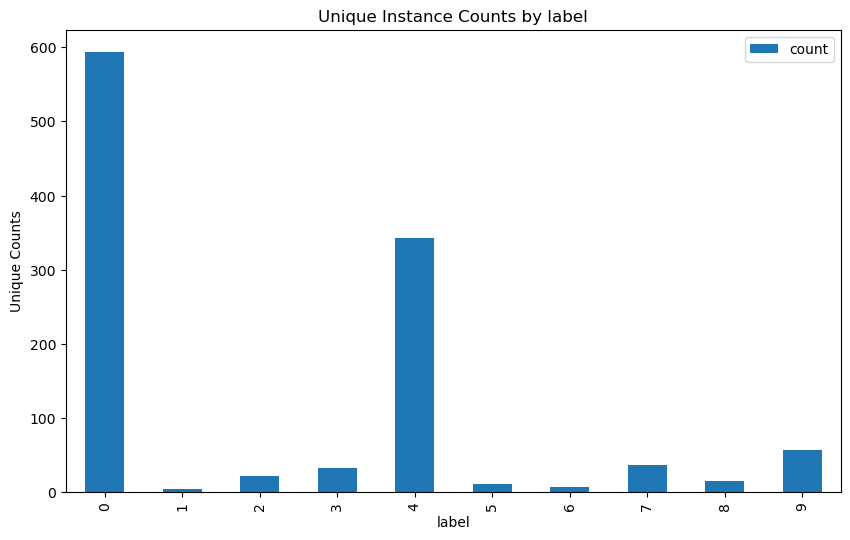

In [15]:
plot_histogram_single_dataset(spark_df_real, 'label', 'Instance', 'Real')

In [16]:
def compare_unique_identifiers(spark_df, label_column, unique_values_table):
    # Step 1: Identify columns classified as "Identifier"
    identifier_columns = (
        unique_values_table.filter(col("Value Type") == "Identifier")
        .select("Tag")
        .rdd.flatMap(lambda x: x)
        .collect()
    )
    
    # Step 2: For each identifier, count unique values grouped by the label_column
    unique_counts = [
        spark_df.groupBy(label_column).agg(countDistinct(identifier).alias(identifier))
        for identifier in identifier_columns
    ]
    
    # Step 3: Perform successive joins to combine all unique counts into a single DataFrame
    result_df = unique_counts[0]
    for df in unique_counts[1:]:
        result_df = result_df.join(df, on=label_column, how="outer")
    
    return result_df

In [17]:
result_df = compare_unique_identifiers(spark_df_real, 'label', unique_values_table_with_missing)
result_df.show(truncate=False, n=999)

+-----+----+---+--------+
|label|well|id |Instance|
+-----+----+---+--------+
|0    |9   |588|594     |
|1    |3   |4  |4       |
|2    |7   |22 |22      |
|3    |2   |32 |32      |
|4    |7   |343|343     |
|5    |3   |11 |11      |
|6    |2   |6  |6       |
|7    |6   |36 |36      |
|8    |9   |14 |14      |
|9    |15  |57 |57      |
+-----+----+---+--------+



In [18]:
def count_unique_values(spark_df, row_feature, col_feature, count_feature):
    # Fill any null values in row and column features to avoid null grouping
    spark_df = spark_df.fillna({row_feature: "Unknown", col_feature: "Unknown"})
    
    # Step 1: Calculate unique counts by row and column features
    unique_counts_df = (spark_df
                        .groupBy(row_feature, col_feature)
                        .agg(F.countDistinct(count_feature).alias("Unique_Count")))
    
    # Step 2: Directly pivot on the unique counts
    result_df = (unique_counts_df
                 .groupBy(row_feature)
                 .pivot(col_feature)
                 .sum("Unique_Count")
                 .fillna("Unknown"))  # Fill missing values with 0
    
    # Step 3: Sort by the row feature
    result_df = result_df.orderBy(row_feature)

    return result_df

In [19]:
result_df = count_unique_values(spark_df_real, 'label', 'state', 'Instance')
result_df.show(truncate=False)

+-----+----+---+----+----+----+----+----+----+----+----+
|label|null|0.0|1.0 |2.0 |3.0 |4.0 |5.0 |6.0 |7.0 |8.0 |
+-----+----+---+----+----+----+----+----+----+----+----+
|0    |594 |594|1   |NULL|1   |1   |1   |1   |1   |1   |
|1    |4   |4  |NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|
|2    |22  |22 |NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|
|3    |32  |32 |NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|
|4    |343 |343|NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|
|5    |11  |11 |NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|
|6    |6   |6  |NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|
|7    |36  |36 |NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|
|8    |14  |14 |11  |6   |2   |3   |1   |2   |5   |8   |
|9    |57  |57 |NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|
+-----+----+---+----+----+----+----+----+----+----+----+



In [20]:
result_df = count_unique_values(spark_df_real, 'label', 'class', 'Instance')
result_df.show(truncate=False)

+-----+----+----+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+
|label|null|0.0 |1.0 |2.0 |3.0 |4.0 |5.0 |6.0 |7.0 |8.0 |9.0 |101.0|102.0|105.0|106.0|107.0|108.0|109.0|
+-----+----+----+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+
|0    |594 |594 |NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL |NULL |NULL |NULL |NULL |NULL |NULL |
|1    |4   |4   |4   |NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|4    |NULL |NULL |NULL |NULL |NULL |NULL |
|2    |22  |22  |NULL|11  |NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL |22   |NULL |NULL |NULL |NULL |NULL |
|3    |32  |NULL|NULL|NULL|32  |NULL|NULL|NULL|NULL|NULL|NULL|NULL |NULL |NULL |NULL |NULL |NULL |NULL |
|4    |343 |NULL|NULL|NULL|NULL|343 |NULL|NULL|NULL|NULL|NULL|NULL |NULL |NULL |NULL |NULL |NULL |NULL |
|5    |11  |11  |NULL|NULL|NULL|NULL|7   |NULL|NULL|NULL|NULL|NULL |NULL |11   |NULL |NULL |NULL |NULL |
|6    |6   |6   |NULL|NULL|NULL|NULL|NULL|6   |NULL|NUL

In [21]:
result_df = count_unique_values(spark_df_real, 'state', 'class', 'Instance')
result_df.show(truncate=False)

+-----+----+----+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+
|state|null|0.0 |1.0 |2.0 |3.0 |4.0 |5.0 |6.0 |7.0 |8.0 |9.0 |101.0|102.0|105.0|106.0|107.0|108.0|109.0|
+-----+----+----+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+
|NULL |1119|NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL |NULL |NULL |NULL |NULL |NULL |NULL |
|0.0  |NULL|744 |4   |11  |32  |343 |7   |6   |5   |1   |3   |4    |22   |11   |6    |36   |8    |14   |
|1.0  |NULL|1   |NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL |NULL |NULL |NULL |NULL |11   |NULL |
|2.0  |NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|5   |NULL|NULL |NULL |NULL |NULL |NULL |1    |NULL |
|3.0  |NULL|1   |NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL |NULL |NULL |NULL |NULL |2    |NULL |
|4.0  |NULL|1   |NULL|NULL|NULL|NULL|NULL|NULL|NULL|3   |NULL|NULL |NULL |NULL |NULL |NULL |1    |NULL |
|5.0  |NULL|1   |NULL|NULL|NULL|NULL|NULL|NULL|NULL|NUL

# Unique Wells

In [22]:
# Print all the unique well names
unique_wells = spark_df_real.select("well").distinct().rdd.flatMap(lambda x: x).collect()
print(f'Unique well names: {unique_wells}')

Unique well names: ['WELL-00034', 'WELL-00033', 'WELL-00016', 'WELL-00035', 'WELL-00020', 'WELL-00010', 'WELL-00014', 'WELL-00042', 'WELL-00041', 'WELL-00037', 'WELL-00006', 'WELL-00040', 'WELL-00005', 'WELL-00008', 'WELL-00039', 'WELL-00038', 'WELL-00002', 'WELL-00036', 'WELL-00001', 'WELL-00015', 'WELL-00007', 'WELL-00004', 'WELL-00003', 'WELL-00019', 'WELL-00024', 'WELL-00022', 'WELL-00021', 'WELL-00023', 'WELL-00027', 'WELL-00029', 'WELL-00031', 'WELL-00025', 'WELL-00026', 'WELL-00030', 'WELL-00028', 'WELL-00032', 'WELL-00013', 'WELL-00011', 'WELL-00012', 'WELL-00009']


In [23]:
def plot_well_frequency(spark_df, label_column, count_basis, df_name='Dataset'):
    # Step 1: Ensure values in the label_column are strings
    spark_df = spark_df.withColumn(label_column, F.col(label_column).cast("string"))

    # Step 2: Count unique values based on count_basis
    label_counts_df = (spark_df
                       .groupBy(label_column)
                       .agg(F.countDistinct(count_basis).alias("Unique_Count")))

    # Step 3: Convert Spark DataFrame to Pandas DataFrame for plotting
    pandas_df = label_counts_df.toPandas()

    # Step 4: Create a new DataFrame for plotting, set the index to sorted label names
    all_labels = sorted(pandas_df[label_column].unique())
    result_df = pd.DataFrame({df_name: pandas_df.set_index(label_column)["Unique_Count"]}, index=all_labels)

    # Step 5: Sort by frequency of counts in descending order
    result_df = result_df.sort_values(df_name, ascending=False)

    # Step 6: Plot the frequency bar chart
    result_df.plot(kind='bar', figsize=(10, 6), width=0.8, legend=False)
    plt.title(f'Unique {count_basis} Counts by {label_column}')
    plt.ylabel(f'Unique {count_basis} Counts')
    plt.xlabel(label_column)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Display the result DataFrame for review
    print(result_df)

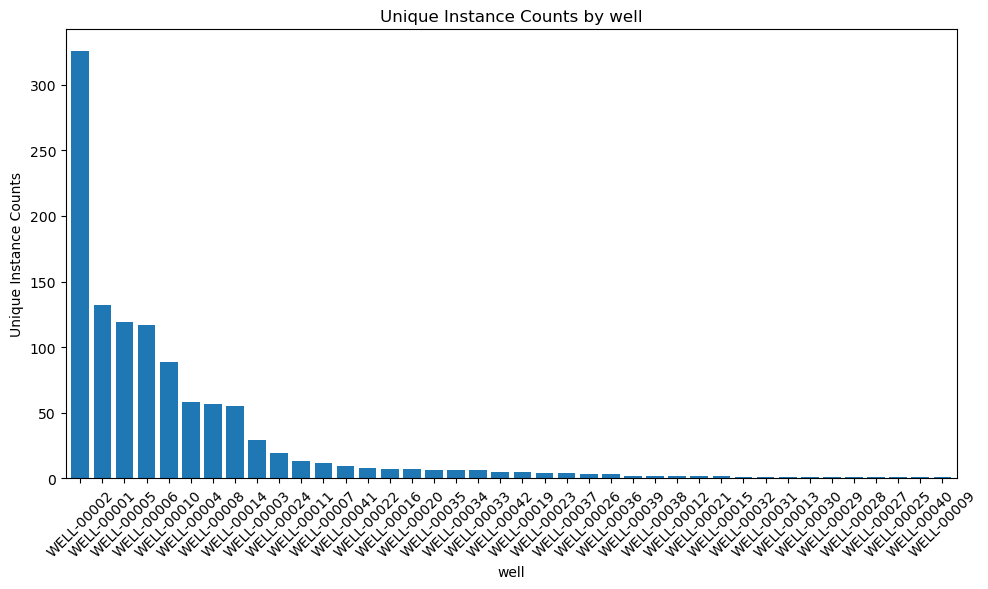

            Real
WELL-00002   326
WELL-00001   132
WELL-00005   119
WELL-00006   117
WELL-00010    89
WELL-00004    58
WELL-00008    57
WELL-00014    55
WELL-00003    29
WELL-00024    19
WELL-00011    13
WELL-00007    12
WELL-00041     9
WELL-00022     8
WELL-00016     7
WELL-00020     7
WELL-00035     6
WELL-00034     6
WELL-00033     6
WELL-00042     5
WELL-00019     5
WELL-00023     4
WELL-00037     4
WELL-00026     3
WELL-00036     3
WELL-00039     2
WELL-00038     2
WELL-00012     2
WELL-00021     2
WELL-00015     2
WELL-00032     1
WELL-00031     1
WELL-00013     1
WELL-00030     1
WELL-00029     1
WELL-00028     1
WELL-00027     1
WELL-00025     1
WELL-00040     1
WELL-00009     1


In [24]:
plot_well_frequency(spark_df_real, 'well', 'Instance', 'Real')

In [26]:
count_unique_values(spark_df_real, 'well', 'label', 'Instance').show(truncate=False, n=999)

+----------+----+----+----+----+----+----+----+----+----+----+
|well      |0   |1   |2   |3   |4   |5   |6   |7   |8   |9   |
+----------+----+----+----+----+----+----+----+----+----+----+
|WELL-00001|93  |1   |NULL|1   |36  |NULL|NULL|1   |NULL|NULL|
|WELL-00002|209 |1   |1   |NULL|112 |NULL|3   |NULL|NULL|NULL|
|WELL-00003|26  |NULL|3   |NULL|NULL|NULL|NULL|NULL|NULL|NULL|
|WELL-00004|12  |NULL|NULL|NULL|43  |NULL|3   |NULL|NULL|NULL|
|WELL-00005|81  |NULL|NULL|NULL|38  |NULL|NULL|NULL|NULL|NULL|
|WELL-00006|113 |2   |NULL|NULL|NULL|NULL|NULL|2   |NULL|NULL|
|WELL-00007|2   |NULL|NULL|NULL|10  |NULL|NULL|NULL|NULL|NULL|
|WELL-00008|57  |NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|
|WELL-00009|NULL|NULL|1   |NULL|NULL|NULL|NULL|NULL|NULL|NULL|
|WELL-00010|NULL|NULL|1   |NULL|83  |NULL|NULL|NULL|NULL|5   |
|WELL-00011|NULL|NULL|13  |NULL|NULL|NULL|NULL|NULL|NULL|NULL|
|WELL-00012|NULL|NULL|2   |NULL|NULL|NULL|NULL|NULL|NULL|NULL|
|WELL-00013|NULL|NULL|1   |NULL|NULL|NULL|NULL|NULL|NUL

In [29]:
# Stop Spark session when done
spark.stop()

ConnectionRefusedError: [Errno 61] Connection refused